In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [8]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [3]:
load_dotenv()

True

In [9]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [10]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'neutral', 'negative'] = Field(description="The sentiment of the review")


In [12]:
structured_model = model.with_structured_output(SentimentSchema)

In [16]:
prompt = "What is the sentiment of the following review - The software is very good"
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [17]:
# defining state
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['positive', 'neutral', 'negative']
    diagnosis: dict
    response: str
    

In [26]:
# defining sentiment function
def find_sentiment(state: ReviewState):
    
    prompt = f"Find the sentiment for the following sentiment - {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [30]:
def sentiment_check(state: ReviewState) -> Literal['positive_review', 'neutral_review', 'negative_review']:
    if state['sentiment'] == 'positive':
        return 'positive_review'
    elif state['sentiment'] == 'neutral':
        return 'neutral_review'
    else:
        return 'negative_review'

In [ ]:
graph = StateGraph(ReviewState)

# adding nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('find_sentiment', 'sentiment_check')



# adding edges
graph.add_edge(START, "find_sentiment")
graph.add_edge("find_sentiment", END)

# compiling the graph
workflow = graph.compile()

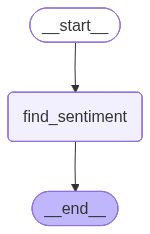

In [28]:
workflow

In [23]:
# defining initial state
initial_state: ReviewState = {
    "review": "The software is very good",
    "sentiment": "",
    "diagnosis": {},
    "response": ""
}

In [29]:
workflow.invoke(initial_state)

{'review': 'The software is very good',
 'sentiment': 'positive',
 'diagnosis': {},
 'response': ''}